In [1]:
import numpy
from scipy.constants import c as light_speed
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams
from matplotlib import rc
import healpy
rcParams['mathtext.default'] = 'regular'

In [2]:
def jones_matrix_short_dipole(theta, phi):
    jones_matrix = numpy.zeros((theta.shape)+ (2,2), dtype=complex)
    
    jones_matrix[...,0,0] = numpy.cos(theta)*numpy.sin(phi)
    jones_matrix[...,0,1] = numpy.cos(phi)
    jones_matrix[...,1,0] = numpy.cos(theta)*numpy.cos(phi)
    jones_matrix[...,1,1] = -numpy.sin(theta)
    
    return jones_matrix

In [3]:
def cross_dipole(theta):
    response = numpy.cos(theta)
    return response

In [4]:
def electric_field_ground_plane(theta, frequency=150e6 , height= 0.3):
    wavelength = light_speed/frequency
    ground_plane_electric_field = numpy.sin(2.*numpy.pi*height/wavelength*numpy.cos(theta))
    return ground_plane_electric_field

In [5]:
def get_array_factor(x,y,z, weights ,theta, phi,  theta_pointing = 0, phi_pointing = 0, frequency=150e6):
    wavelength = light_speed/frequency
    number_dipoles= len(x)
    k_x = (2.*numpy.pi/wavelength)*numpy.sin(theta)*numpy.sin(phi)
    k_y = (2.*numpy.pi/wavelength)*numpy.sin(theta)*numpy.cos(phi)
    k_z = (2.*numpy.pi/wavelength)*numpy.cos(theta)
    
    k_x0 = (2.*numpy.pi/wavelength)*numpy.sin(theta_pointing)*numpy.sin(phi_pointing) 
    k_y0 = (2.*numpy.pi/wavelength)*numpy.sin(theta_pointing)*numpy.cos(phi_pointing)
    k_z0 = (2.*numpy.pi/wavelength)*numpy.cos(theta_pointing)
    array_factor_map = numpy.zeros(theta.shape, dtype=complex)
    for i in range(number_dipoles):
        array_factor_map += weights[i]*numpy.exp(1.j*((k_x - k_x0)*x[i] + (k_y - k_y0)*y[i] + (k_z - k_z0)*z[i]))
    
    
    return array_factor_map/sum(weights)    

In [6]:
def ska_station_response(tt, pp, target_theta=0, target_phi=0,  frequency=150e6, weights_xx = 1, weights_yy = 1, 
                         station_radius = 5, number_dipoles = 256):
    
    x_offsets = numpy.random.uniform(0,1,number_dipoles)*station_radius
    y_offsets = numpy.random.uniform(0,1,number_dipoles)*station_radius
    z_offsets = numpy.random.uniform(0,0,number_dipoles)
    
    weights_xx += numpy.zeros(x_offsets.shape) 
    weights_yy += numpy.zeros(x_offsets.shape) 

        
    EW_dipole_jones_matrix = jones_matrix_short_dipole(tt, pp)
    NS_dipole_jones_matrix = jones_matrix_short_dipole(tt, pp + numpy.pi/2.)

    ground_plane_field = electric_field_ground_plane(tt, frequency)
    
    array_factor_xx = get_array_factor(x_offsets, y_offsets, z_offsets, weights_xx, tt, pp, target_theta, target_phi,
                                    frequency)
    array_factor_yy = get_array_factor(x_offsets, y_offsets, z_offsets, weights_yy, tt, pp, target_theta, target_phi,
                                    frequency)
    
    station_response = numpy.zeros(EW_dipole_jones_matrix.shape, dtype = complex)

    station_response[...,0,0] = ground_plane_field*(array_factor_xx*EW_dipole_jones_matrix[...,0,0]
                                           +array_factor_yy*NS_dipole_jones_matrix[...,0,0])
    station_response[...,0,1] = ground_plane_field*(array_factor_xx*EW_dipole_jones_matrix[...,0,1]
                                           +array_factor_yy*NS_dipole_jones_matrix[...,0,1])
    station_response[...,1,0] = ground_plane_field*(array_factor_xx*EW_dipole_jones_matrix[...,1,0]
                                           +array_factor_yy*NS_dipole_jones_matrix[...,1,0])
    station_response[...,1,1] = ground_plane_field*(array_factor_xx*EW_dipole_jones_matrix[...,1,1]
                                           +array_factor_yy*NS_dipole_jones_matrix[...,1,1])
    
    return station_response

In [7]:
def simple_ska_station_response(tt, pp, target_theta=0, target_phi=0,  frequency=150e6, weights_xx = 1, weights_yy = 1, 
                         station_radius = 5, number_dipoles = 256):
    
    x_offsets = numpy.random.uniform(0,1,number_dipoles)*station_radius
    y_offsets = numpy.random.uniform(0,1,number_dipoles)*station_radius
    z_offsets = numpy.random.uniform(0,0,number_dipoles)
    
    weights_xx += numpy.zeros(x_offsets.shape) 

        
    dipole_jones_matrix = cross_dipole(tt)

    ground_plane_field = electric_field_ground_plane(tt, frequency)
    
    array_factor= get_array_factor(x_offsets, y_offsets, z_offsets, weights_xx, tt, pp, target_theta, target_phi,
                                    frequency)
    

    tile_response = array_factor*ground_plane_field*dipole_jones_matrix

    
    return tile_response

In [8]:
def healpy_plotting(tt, pp, tile_response):
    nside =32
    n_pixels = healpy.nside2npix(nside)
    
    indices = healpy.ang2pix(nside, tt.flatten(), pp.flatten())
    healpixmap = numpy.zeros((n_pixels), dtype=complex)

    healpixmap[indices] += tile_response.flatten()

    healpy.orthview(numpy.abs(healpixmap), rot =[0,90,0], norm='hist')
    healpy.graticule()

### Calculate Response Phase Array ( Short Dipole x Ground Screen x Array Factor)

In [9]:
target_theta = 0
target_phi = 0
theta = numpy.linspace(0,numpy.pi/2.,50)
phi = numpy.linspace(0, 2.*numpy.pi,200)
tt, pp = numpy.meshgrid(theta, phi)

tile_response = ska_station_response(tt, pp, frequency=150e6, target_theta=target_theta, target_phi=target_phi)

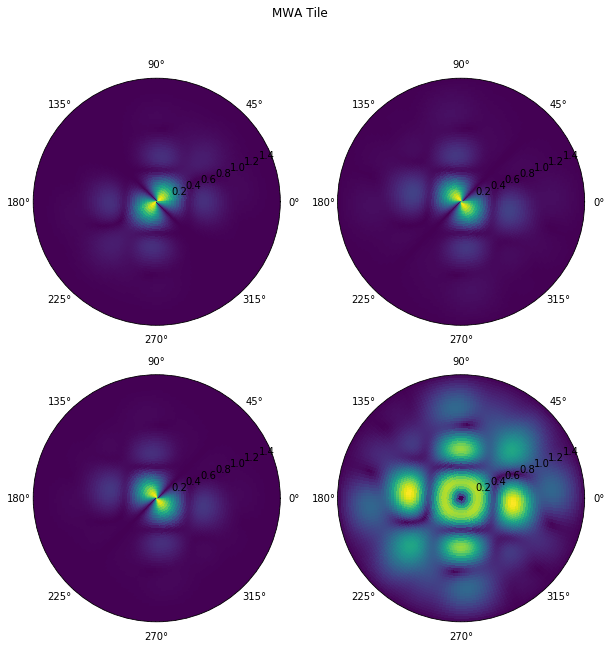

In [10]:
%matplotlib inline

fig = pyplot.figure(figsize = (10,10))
pol_xx = fig.add_subplot(221, polar=True)
pol_xy = fig.add_subplot(222, polar=True)
pol_yx = fig.add_subplot(223, polar=True)
pol_yy = fig.add_subplot(224, polar=True)

pol_xx.pcolormesh(pp,tt, numpy.abs(tile_response[...,0,0]))
pol_xy.pcolormesh(pp,tt, numpy.abs(tile_response[...,0,1]))
pol_yx.pcolormesh(pp,tt, numpy.abs(tile_response[...,1,0]))
pol_yy.pcolormesh(pp,tt, numpy.abs(tile_response[...,1,1]))
fig.suptitle("MWA Tile")
pyplot.show()

### Healpy version

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/Users/ronniyjoseph/anaconda2/envs/python3/lib/python3.6/site-packages/healpy/projaxes.py:387: RuntimeWarning: invalid value encountered in greater
  w=np.where(d2 > threshold)[0]


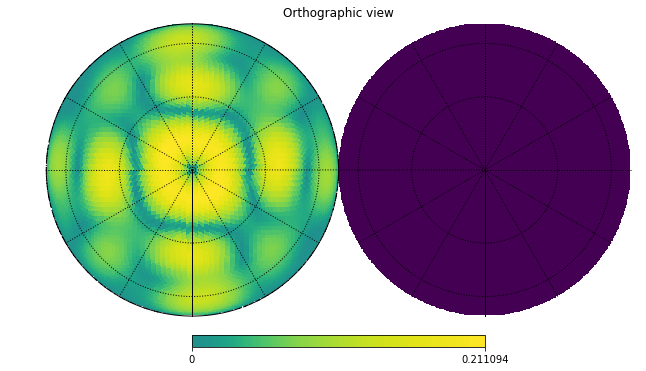

In [11]:
%matplotlib inline
nside =32

target_theta = 0.
target_phi = 0

theta = numpy.linspace(0,numpy.pi/2.,100)
phi = numpy.linspace(0, 2.*numpy.pi,500)
tt, pp = numpy.meshgrid(theta, phi)
tile_response = ska_station_response(tt, pp, frequency=150e6, target_theta=target_theta, target_phi=target_phi, station_radius=5)

healpy_plotting(tt, pp, tile_response[...,1,1])

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/Users/ronniyjoseph/anaconda2/envs/python3/lib/python3.6/site-packages/healpy/projaxes.py:387: RuntimeWarning: invalid value encountered in greater
  w=np.where(d2 > threshold)[0]


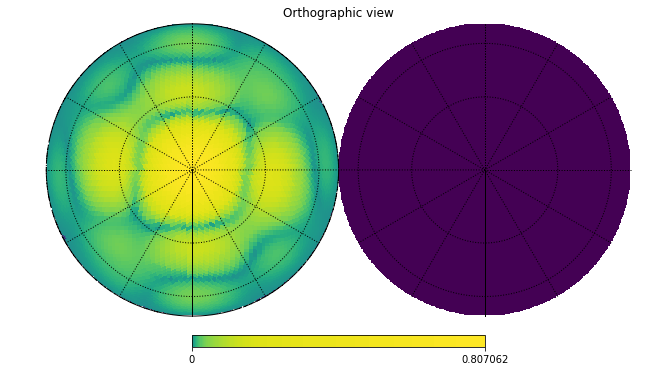

In [12]:
%matplotlib inline
nside =32

target_theta = 0.
target_phi = 0

theta = numpy.linspace(0,numpy.pi/2.,100)
phi = numpy.linspace(0, 2.*numpy.pi,500)
tt, pp = numpy.meshgrid(theta, phi)
tile_response = simple_ska_station_response(tt, pp, frequency=150e6, target_theta=target_theta, target_phi=target_phi, station_radius=5)

healpy_plotting(tt, pp, tile_response)

### Let's calculate a single slice, for different tile realisations

In [17]:
def station_realisation(theta, phi, n_realisations):

    jones_matrix = numpy.zeros((theta.shape[0]*phi.shape[0],)+(n_realisations,2,2), dtype=complex)

    
    for i in range(n_realisations):
        #One or two polarizations?
        #number_dead_dipoles = numpy.random.randint(0,3,1)
        #dipole_indices = numpy.random.randint(0,31,number_dead_dipoles)
        
        weights_xx = 1
        weights_yy = 1
        
        station_response =  ska_station_response(theta, phi, target_theta=0, target_phi=0,  
                                           frequency=150e6, weights_xx =weights_xx, weights_yy = weights_yy)

        jones_matrix[:,i,0,0] = station_response[...,0,0].flatten()
        jones_matrix[:,i,0,1] = station_response[...,0,1].flatten()
        jones_matrix[:,i,1,0] = station_response[...,1,0].flatten()
        jones_matrix[:,i,1,1] = station_response[...,1,1].flatten()

    
    return jones_matrix

def compute_deviations(n_realisations, jones_realisations, jones_means):
    jones_deviations = numpy.zeros_like(jones_realisations)
    
    for i in range(n_realisations):
        jones_deviations[:, i,...] = jones_realisations[:,i,...] - jones_means
    return jones_deviations



In [14]:
number_realisations = 1000
phi = numpy.array([numpy.pi/3.])
theta = numpy.linspace(-numpy.pi/2.,numpy.pi/2.,50)
zenith_angle = numpy.degrees(theta)
jones_realisations = station_realisation(theta, phi, number_realisations)

mean_beam = numpy.zeros((len(theta),2,2), dtype=complex)
mean_beam[...,0,0] = numpy.mean(jones_realisations[:,:,0,0], axis = 1)
mean_beam[...,1,0] = numpy.mean(jones_realisations[:,:,1,0], axis = 1)
mean_beam[...,0,1] = numpy.mean(jones_realisations[:,:,0,1], axis = 1)
mean_beam[...,1,1] = numpy.mean(jones_realisations[:,:,1,1], axis = 1)


In [19]:
model_deviations = compute_deviations(number_realisations, jones_realisations, mean_beam)

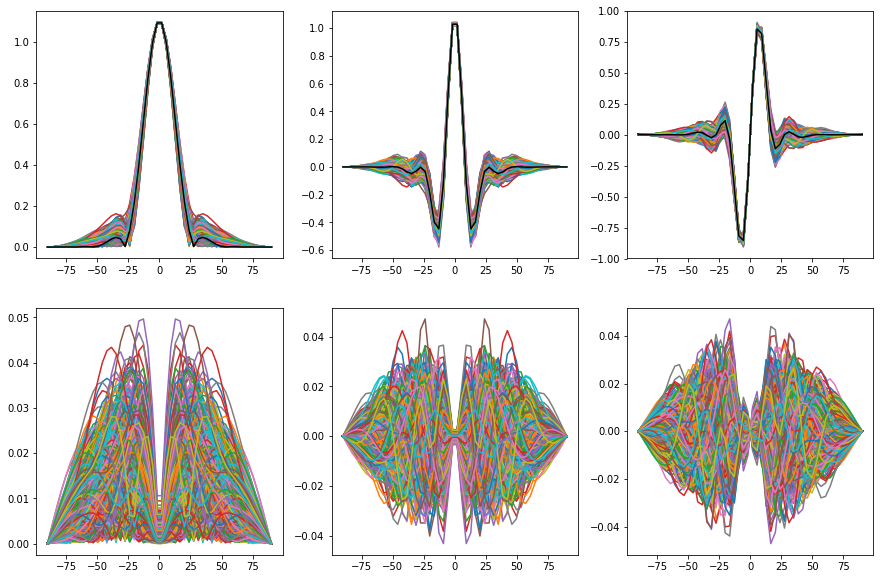

In [30]:
beam_figure, beam_axes = pyplot.subplots(2,3, figsize = (15, 10))


beam_axes[0,0].plot(zenith_angle, numpy.abs(jones_realisations[...,:,0,0]))
beam_axes[0,0].plot(zenith_angle, numpy.abs(mean_beam[...,:,0,0]), 'k')

beam_axes[0,1].plot(zenith_angle, numpy.real(jones_realisations[...,:,0,0]))
beam_axes[0,1].plot(zenith_angle, numpy.real(mean_beam[...,:,0,0]), 'k')

beam_axes[0,2].plot(zenith_angle, numpy.imag(jones_realisations[...,:,0,0]))
beam_axes[0,2].plot(zenith_angle, numpy.imag(mean_beam[...,:,0,0]), 'k')


beam_axes[1,0].plot(zenith_angle, numpy.abs(model_deviations[...,:,0,1]))
beam_axes[1,1].plot(zenith_angle, numpy.real(model_deviations[...,:,0,1]))
beam_axes[1,2].plot(zenith_angle, numpy.imag(model_deviations[...,:,0,1]))

#amp =  numpy.max(numpy.mean())
#functional_dev_subb.plot(zenith_angle, numpy.real(model_deviations[...,:,0,1]))

dev_figure.savefig("beam_realisation.png")
pyplot.show()

In [ ]:
Cov_B_zenith_xx = numpy.cov(jones_realisations[...,0,0])
Cov_B_zenith_xy = numpy.cov(jones_realisations[...,0,1])
Cov_B_zenith_yx = numpy.cov(jones_realisations[...,1,0])
Cov_B_zenith_yy = numpy.cov(jones_realisations[...,1,1])

In [ ]:
figure = pyplot.figure(figsize = (10,8))

cov_xx_sub = figure.add_subplot(221)
cov_xy_sub = figure.add_subplot(222)
cov_yx_sub = figure.add_subplot(223)
cov_yy_sub = figure.add_subplot(224)

cov_xx_plot = cov_xx_sub.imshow(numpy.abs(Cov_B_zenith_xx))
cov_xy_plot = cov_xy_sub.imshow(numpy.abs(Cov_B_zenith_xy))
cov_yx_plot = cov_yx_sub.imshow(numpy.abs(Cov_B_zenith_yx))
cov_yy_plot = cov_yy_sub.imshow(numpy.abs(Cov_B_zenith_yy))

#cov_xx_plot = cov_xx_sub.pcolor(zenith_angle,zenith_angle, numpy.abs(Cov_B_zenith_xx))
#cov_xy_plot = cov_xy_sub.pcolor(zenith_angle,zenith_angle, numpy.abs(Cov_B_zenith_xy))
#cov_yx_plot = cov_yx_sub.pcolor(zenith_angle,zenith_angle, numpy.abs(Cov_B_zenith_yx))
#cov_yy_plot = cov_yy_sub.pcolor(zenith_angle,zenith_angle, numpy.abs(Cov_B_zenith_yy))

cov_xx_sub.set_title(r"$\Sigma_{\mathrm{beam},XX}$")
cov_xy_sub.set_title(r"$\Sigma_{\mathrm{beam},XY}$")
cov_yx_sub.set_title(r"$\Sigma_{\mathrm{beam},YX}$")
cov_yy_sub.set_title(r"$\Sigma_{\mathrm{beam},YY}$")

cov_xx_sub.set_ylabel("Zenith Angle [deg]")
cov_yx_sub.set_ylabel("Zenith Angle [deg]")
cov_yx_sub.set_xlabel("Zenith Angle [deg]")
cov_yy_sub.set_xlabel("Zenith Angle [deg]")

pyplot.colorbar(cov_xx_plot,ax=cov_xx_sub)
pyplot.colorbar(cov_xy_plot,ax=cov_xy_sub)
pyplot.colorbar(cov_yx_plot,ax=cov_yx_sub)
pyplot.colorbar(cov_yy_plot,ax=cov_yy_sub)

figure.suptitle(r"Beam Covariance $\theta_{AZ} = 0^{\circ}$")
figure.savefig("beam_covariance.png")

### Full Sky Covariance Matrix

In [ ]:
number_realisations = 1000
phi = numpy.linspace(0,2.*numpy.pi,50)
theta = numpy.linspace(-numpy.pi/2.,numpy.pi/2.,50)
zenith_angle = numpy.degrees(theta)
azimuth_angle= numpy.degrees(phi)
jones_realisations, model_deviations = tile_realisation(theta, phi, number_realisations)

jones_model = mwa_tile_response(theta, phi,target_theta=0, target_phi=0,  
                                           frequency=150e6)



In [ ]:
Cov_B_zenith_xx = numpy.cov(jones_realisations[...,0,0])
Cov_B_zenith_xy = numpy.cov(jones_realisations[...,0,1])
Cov_B_zenith_yx = numpy.cov(jones_realisations[...,1,0])
Cov_B_zenith_yy = numpy.cov(jones_realisations[...,1,1])

In [ ]:
from matplotlib.ticker import FuncFormatter


%matplotlib notebook
figure = pyplot.figure(figsize = (12,8))

cov_xx_sub = figure.add_subplot(221)
cov_xy_sub = figure.add_subplot(222)
cov_yx_sub = figure.add_subplot(223)
cov_yy_sub = figure.add_subplot(224)




#cov_xx_plot = cov_xx_sub.imshow(numpy.abs(Cov_B_zenith_xx))
#cov_xy_plot = cov_xy_sub.imshow(numpy.abs(Cov_B_zenith_xy))
#cov_yx_plot = cov_yx_sub.imshow(numpy.abs(Cov_B_zenith_yx))
#cov_yy_plot = cov_yy_sub.imshow(numpy.abs(Cov_B_zenith_yy))

tt,pp = numpy.meshgrid(zenith_angle, azimuth_angle)

cov_xx_plot = cov_xx_sub.pcolormesh(numpy.abs(Cov_B_zenith_xx))
cov_xy_plot = cov_xy_sub.pcolormesh(numpy.abs(Cov_B_zenith_xy))
cov_yx_plot = cov_yx_sub.pcolormesh(numpy.abs(Cov_B_zenith_yx))
cov_yy_plot = cov_yy_sub.pcolormesh(numpy.abs(Cov_B_zenith_yy))

title_pad = -0.1
#cov_xx_sub.set_title(r"$\Sigma_{\mathrm{beam},XX}$", pad =title_pad )
#cov_xy_sub.set_title(r"$\Sigma_{\mathrm{beam},XY}$", pad =title_pad )
#cov_yx_sub.set_title(r"$\Sigma_{\mathrm{beam},YX}$", pad =title_pad )
#cov_yy_sub.set_title(r"$\Sigma_{\mathrm{beam},YY}$", pad =title_pad )

cov_xx_sub.set_ylabel("Azimuth [deg]")
cov_yx_sub.set_ylabel("Azimuth [deg]")
cov_yx_sub.set_xlabel("Azimuth [deg]")
cov_yy_sub.set_xlabel("Azimuth [deg]")

padding = 0.1
pyplot.colorbar(cov_xx_plot,ax=cov_xx_sub, pad=padding)
pyplot.colorbar(cov_xy_plot,ax=cov_xy_sub, pad=padding)
pyplot.colorbar(cov_yx_plot,ax=cov_yx_sub, pad=padding)
pyplot.colorbar(cov_yy_plot,ax=cov_yy_sub, pad=padding)


def format_az(tick_val, tick_pos):
    xs = numpy.arange(0,len(pp.flatten()))
    if int(tick_val) in xs:
        return int(pp.flatten()[xs == tick_val])
    else:
        return ''
    

def format_za(tick_val, tick_pos):
    xs = numpy.arange(0,len(tt.flatten()))
    scaled_tick = tick_val*len(tt.flatten())
    if int(scaled_tick) in xs:
        return int(tt.flatten()[xs == int(scaled_tick)])
    else:
        return ''
    
cov_xx_sub2x = cov_xx_sub.twinx()
cov_xy_sub2x = cov_xy_sub.twinx()
cov_yx_sub2x = cov_yx_sub.twinx()
cov_yy_sub2x = cov_yy_sub.twinx()
   
cov_xx_sub2y = cov_xx_sub.twiny()
cov_xy_sub2y = cov_xy_sub.twiny()
cov_yx_sub2y = cov_yx_sub.twiny()
cov_yy_sub2y = cov_yy_sub.twiny()
    
cov_xx_sub.xaxis.set_major_formatter(FuncFormatter(format_az))
cov_xy_sub.xaxis.set_major_formatter(FuncFormatter(format_az))
cov_yx_sub.xaxis.set_major_formatter(FuncFormatter(format_az))
cov_yy_sub.xaxis.set_major_formatter(FuncFormatter(format_az))

cov_xx_sub.yaxis.set_major_formatter(FuncFormatter(format_az))
cov_xy_sub.yaxis.set_major_formatter(FuncFormatter(format_az))
cov_yx_sub.yaxis.set_major_formatter(FuncFormatter(format_az))
cov_yy_sub.yaxis.set_major_formatter(FuncFormatter(format_az))


cov_xx_sub2x.yaxis.set_major_formatter(FuncFormatter(format_za))
cov_xy_sub2x.yaxis.set_major_formatter(FuncFormatter(format_za))
cov_yx_sub2x.yaxis.set_major_formatter(FuncFormatter(format_za))
cov_yy_sub2x.yaxis.set_major_formatter(FuncFormatter(format_za))

cov_xx_sub2y.xaxis.set_major_formatter(FuncFormatter(format_za))
cov_xy_sub2y.xaxis.set_major_formatter(FuncFormatter(format_za))
cov_yx_sub2y.xaxis.set_major_formatter(FuncFormatter(format_za))
cov_yy_sub2y.xaxis.set_major_formatter(FuncFormatter(format_za))



figure.savefig("fulsky_beam_covariance.png")

In [ ]:
%matplotlib inline

In [ ]:
a = range(4)

In [ ]:
2 in numpy.arange(4)